<a href="https://colab.research.google.com/github/DiegoPincheiraIb/Experiencias_EL5206/blob/master/Lab_Vinos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuraciones preliminares

In [27]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import random
from random import randint
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Cargar los Datos

In [28]:
df = pd.read_csv("http://www.forecastingbook.com/mooc/AustralianWines.csv?attredirects=0&d=1")
df.head()

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
0,Jan-80,2585,464,112,1686,85,1954
1,Feb-80,3368,675,118,1591,89,2302
2,Mar-80,3210,703,129,2304,109,3054
3,Apr-80,3111,887,99,1712,95,2414
4,May-80,3756,1139,116,1471,91,2226


Se separa el dataframe en tipos de vinos

In [29]:
fortified = df[['Month','Fortified']]
red = df[['Month','Red ']]
rose = df[['Month','Rose ']]
sparkling = df[['Month','sparkling ']]
sweet_white = df[['Month','Sweet white']]
dry_white = df[['Month','Dry white']]

Se verifica si existen datos nulos

In [30]:
print(fortified.isnull().sum(),
      red.isnull().sum(),
      rose.isnull().sum(),
      sparkling.isnull().sum(),
      sweet_white.isnull().sum(),
      dry_white.isnull().sum()
     )

Month        0
Fortified    0
dtype: int64 Month    0
Red      0
dtype: int64 Month    0
Rose     0
dtype: int64 Month         0
sparkling     0
dtype: int64 Month          0
Sweet white    0
dtype: int64 Month        0
Dry white    0
dtype: int64


Si bien no se presentan datos nulos, se destaca la presencia de dos valores marcados como "*" en "rose". Estos se reemplazarán por un valor aleatorio dentro de la desviación estándar de la media más adelante, utilizando la función Reemplazo_Asteriscos() diseñada en el próximo apartado.

# 2.1: Análisis por tipos de vinos

## Funciones para las predicciones

Se modifica un Dataframe objetivo para que tenga los meses en formato "AAAA-MM-DD". A su vez, se imprime el gráfico de comportamiento, y se descompone el modelo en gráficos que permiten observar su tendencia (Trend), comportamiento estacional (Seasonal), y el ruido presente (Residual).

In [31]:
def Reordenamiento_Meses(DF_Obj, Str_Variable):
  DF_Obj = DF_Obj.groupby('Month')[Str_Variable].sum().reset_index()
  DF_Obj['Month'] = pd.to_datetime(DF_Obj['Month'])
  DF_Obj = DF_Obj.set_index('Month')
  Y_DF_Obj = DF_Obj[Str_Variable].resample('MS').mean()
  Y_DF_Obj.plot(figsize=(18, 8))
  plt.show()
  rcParams['figure.figsize'] = 18, 8
  Decomposition = sm.tsa.seasonal_decompose(Y_DF_Obj, model='additive')
  fig = Decomposition.plot()
  plt.show()
  return Y_DF_Obj

Esta función, dado una serie objetivo, y un booleano opcional, evalua combinaciones de parámetros del método SARIMA, entregando la combinación que da el valor mínimo de AIC, en conjunto con el valor de este. Mediante el booleano opcional es posible imprimir todas las combinaciones si este es igual a True.

In [32]:
def SARIMA_Param(Y_Obj, Show_All = False):
  Min = ''
  Valor_Min = 9999999999999
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
              results = mod.fit()
              if Show_All:
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
              if results.aic <= Valor_Min:
                Valor_Min = results.aic
                Min = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
          except:
              continue
  print('Minimo: ', Min)

Esta función realiza las predicciones.

In [33]:
def Predicciones(Y_Obj, Orden_Obj, Seas_Orden_Obj):
  mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                order=Orden_Obj,
                                seasonal_order=Seas_Orden_Obj,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  results = mod.fit()
  print(results.summary().tables[1])
  results.plot_diagnostics(figsize=(18, 8))
  plt.show()
  pred = results.get_prediction(start = -24,end = len(y_fortified) + 11, dynamic=False)
  pred_ci = pred.conf_int()
  ax = Y_Obj['1984':].plot(label='Observed')
  pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.2)
  ax.set_xlabel('Date')
  ax.set_ylabel('Fortified Sales')
  plt.legend()
  plt.show()
  y_forecasted = pred.predicted_mean
  y_truth = y_fortified['1994-11-01':]
  mse = ((y_forecasted - y_truth) ** 2).mean()
  print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
  print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


In [34]:
def Reemplazo_Asteriscos(DF_Obj, Str_Obj):
  DF_Obj_Copia = DF_Obj.copy()
  DF_Obj_Copia[Str_Obj] = DF_Obj_Copia[Str_Obj].replace('\*', np.nan, regex=True)
  Aux = DF_Obj_Copia[Str_Obj][160:180].dropna().astype(int)
  Media = Aux.mean()
  STD = Aux.std()
  Value = Media + (randint(-int(STD),int(STD)))
  DF_Obj_Copia[Str_Obj] = DF_Obj_Copia[Str_Obj].replace(np.nan, Value, regex=True).astype(int)
  return DF_Obj_Copia

## Fortified

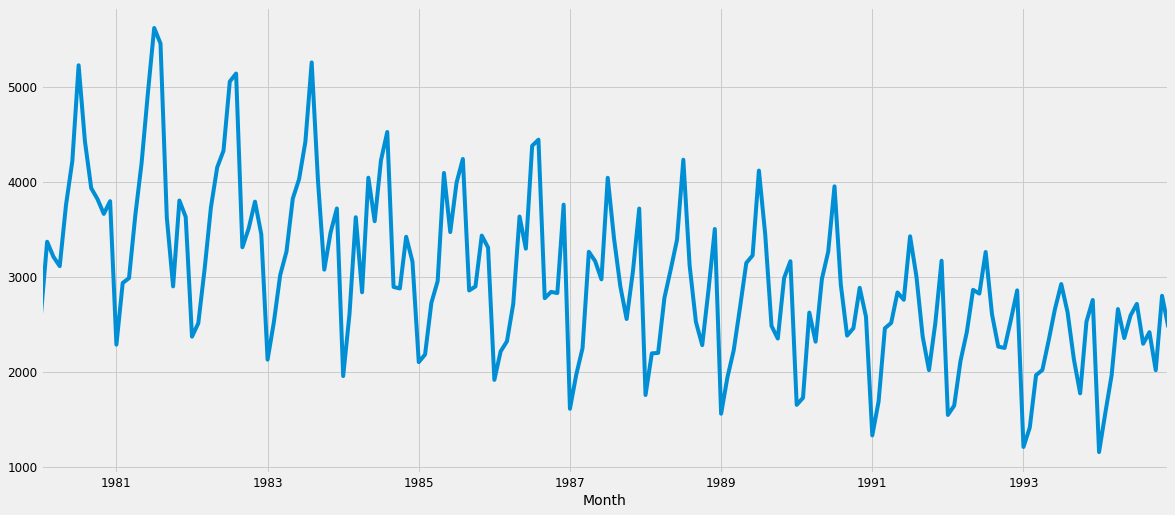

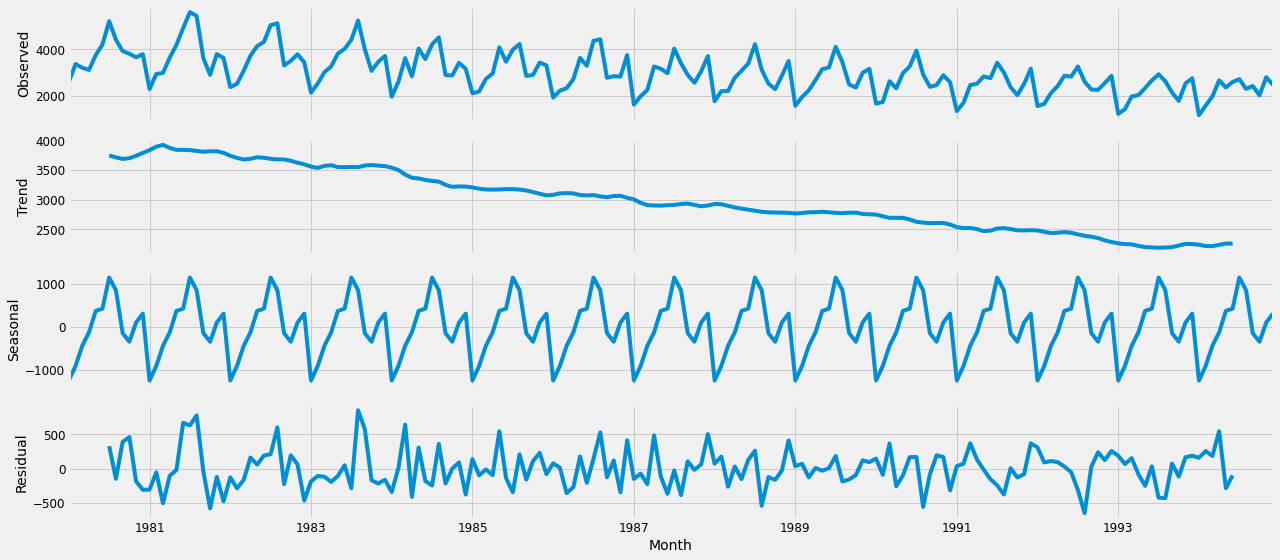

Minimo:  ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2169.0164995610994


In [35]:
y_fortified = Reordenamiento_Meses(fortified, 'Fortified')
SARIMA_Param(y_fortified)

Los resultados anteriores indican que los parámetros más cercanos al modelo consisten en ARIMA(0, 1, 1)x(1, 1, 1, 12)12, con AIC:2169.0164995610994.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0147      0.043    -23.357      0.000      -1.100      -0.930
ar.S.L12       0.0486      0.029      1.702      0.089      -0.007       0.105
ma.S.L12      -0.5260      0.072     -7.274      0.000      -0.668      -0.384
sigma2      7.587e+04   9527.400      7.963      0.000    5.72e+04    9.45e+04


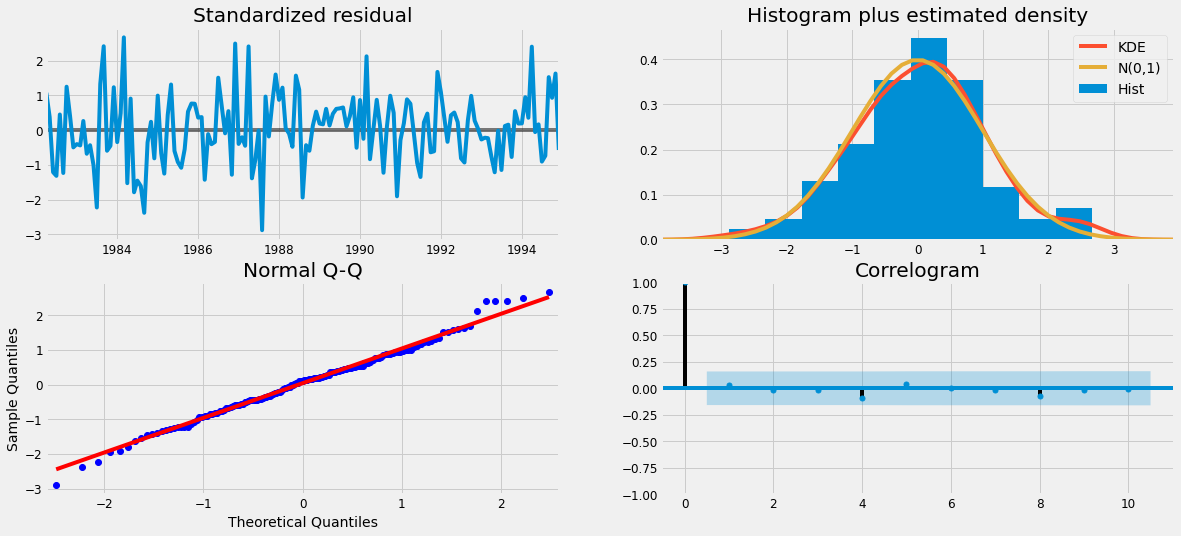

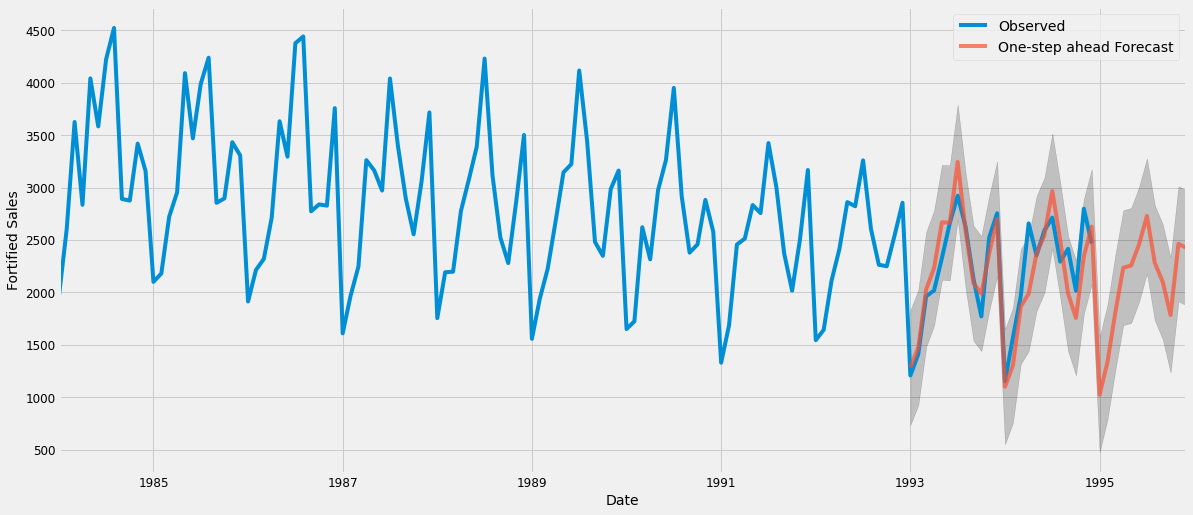

The Mean Squared Error of our forecasts is 116299.1
The Root Mean Squared Error of our forecasts is 341.03


In [36]:
Predicciones(y_fortified, (0,1,1), (1,1,1,12))


## Red

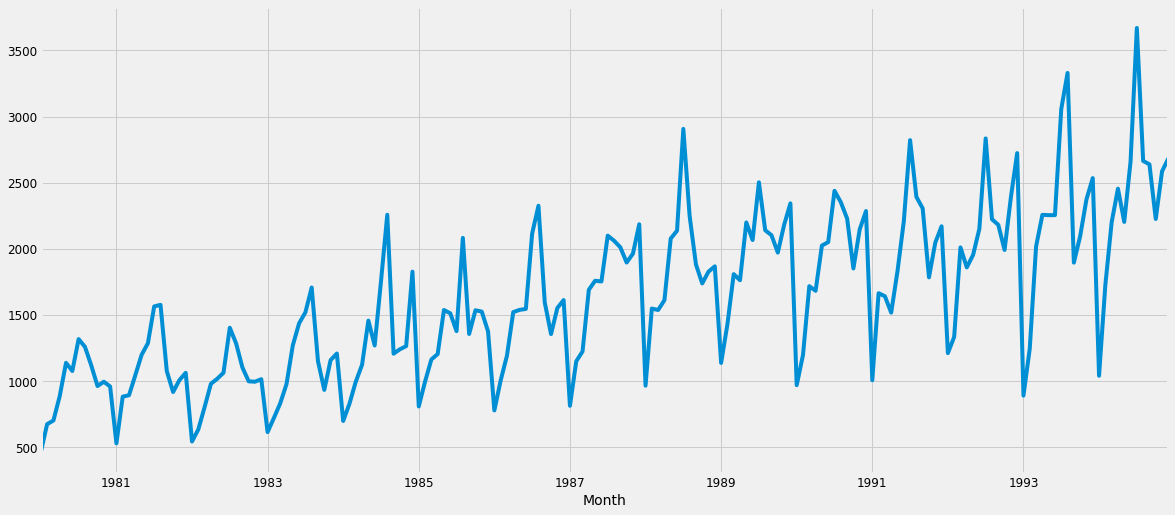

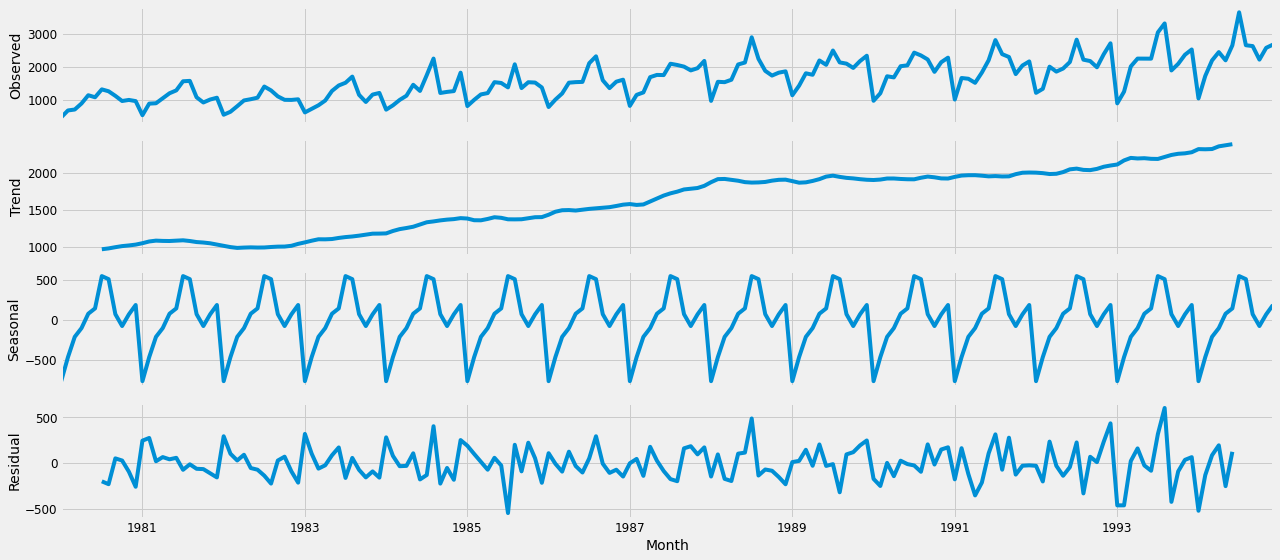

Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2086.391382650295


In [37]:
y_red = Reordenamiento_Meses(red, 'Red ')
SARIMA_Param(y_red)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8846      0.036    -24.827      0.000      -0.954      -0.815
ma.S.L12      -0.6484      0.068     -9.526      0.000      -0.782      -0.515
sigma2      4.629e+04   4233.213     10.934      0.000     3.8e+04    5.46e+04


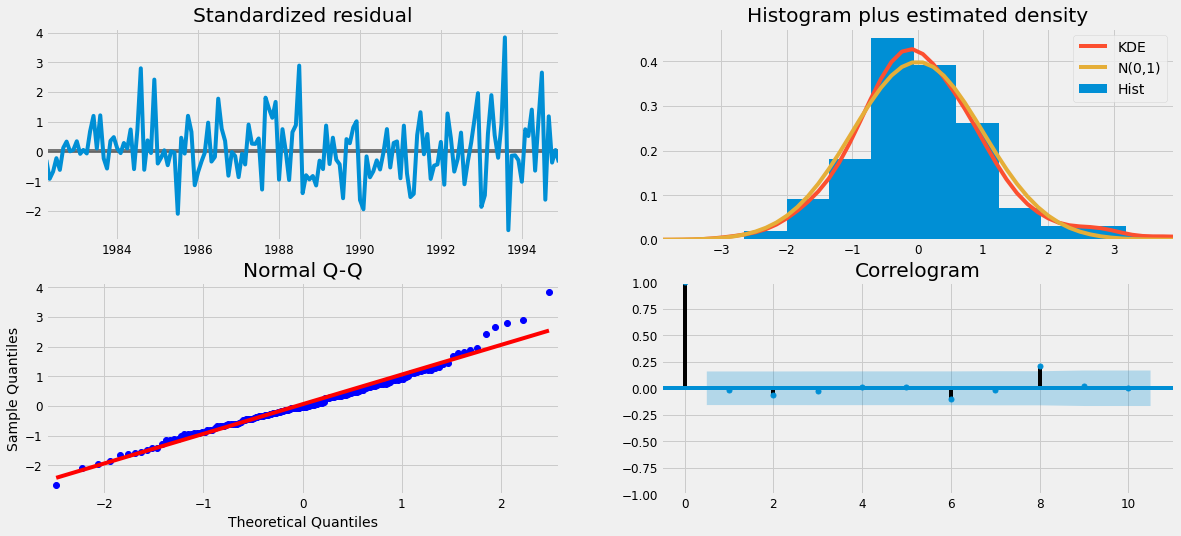

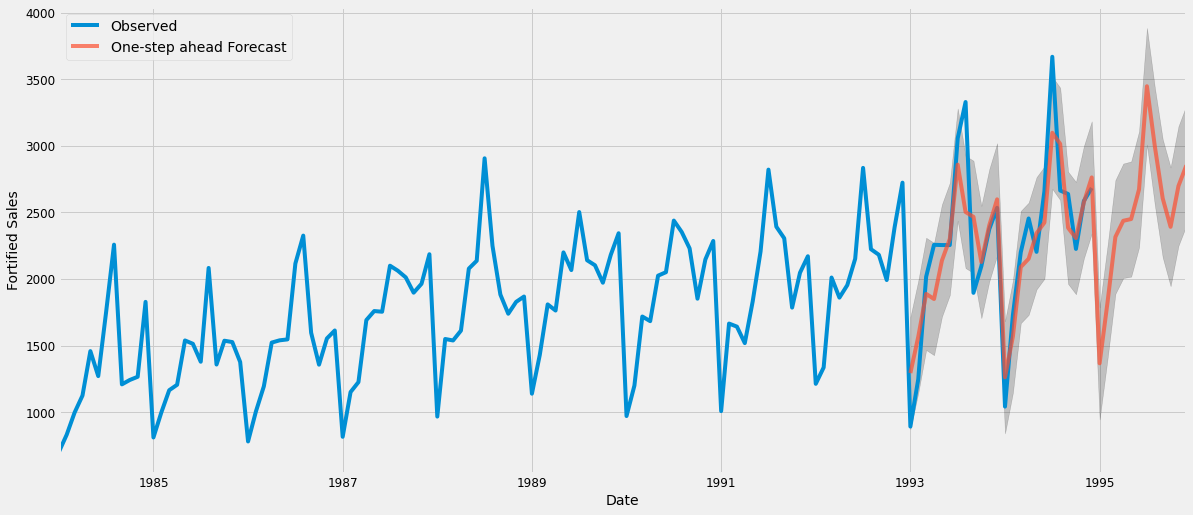

The Mean Squared Error of our forecasts is 68720.6
The Root Mean Squared Error of our forecasts is 262.15


In [38]:
Predicciones(y_red, (0,1,1), (0,1,1,12))


## Rose

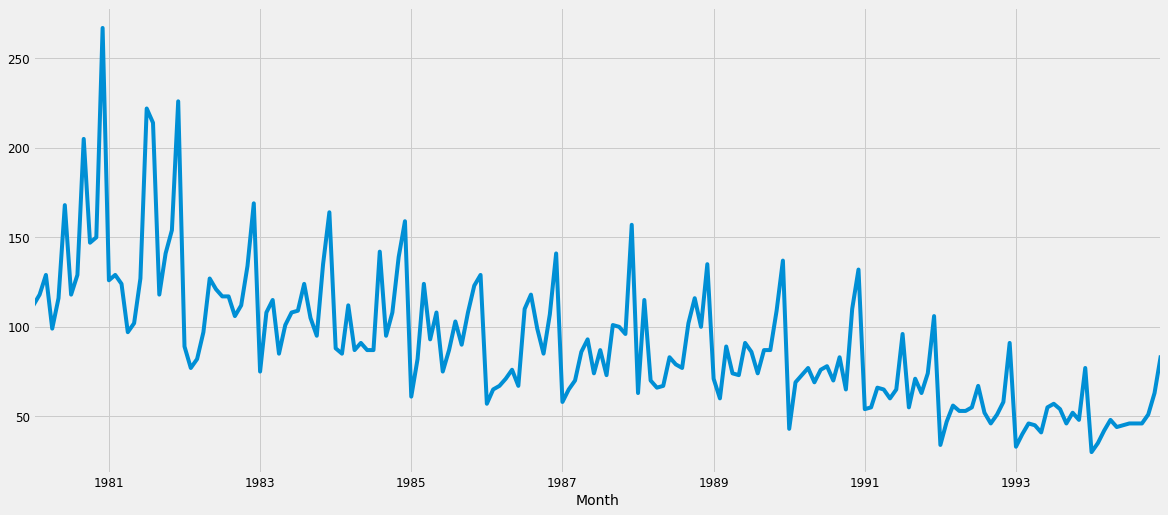

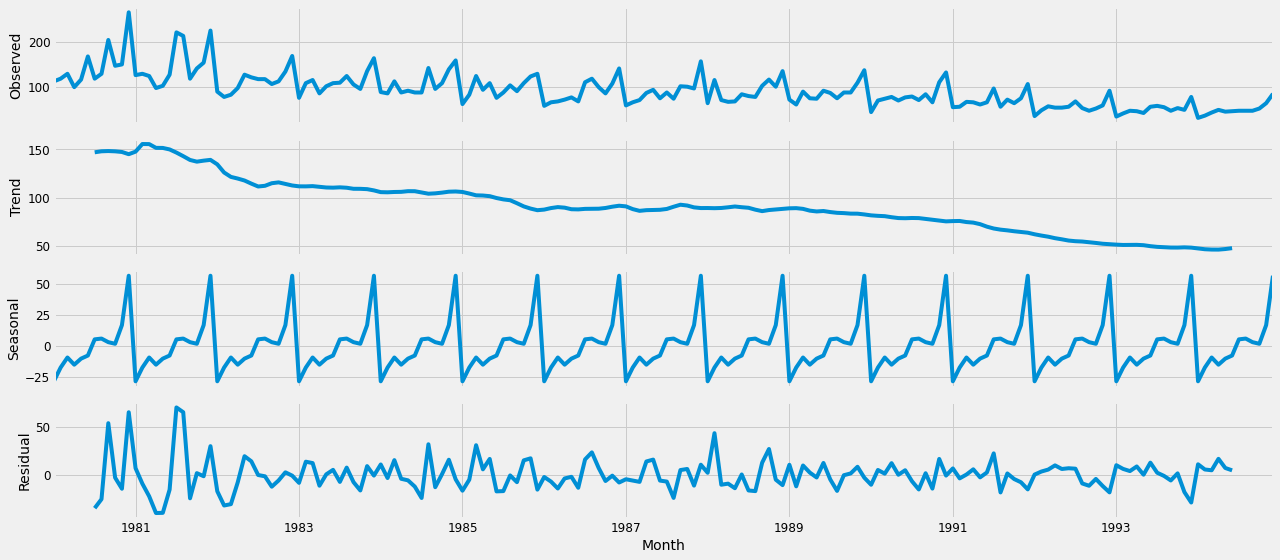

Minimo:  ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1287.070105192518


In [39]:
rose = Reemplazo_Asteriscos(rose, 'Rose ') # Se reemplazan asteriscos
y_rose = Reordenamiento_Meses(rose, 'Rose ')
SARIMA_Param(y_rose)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1835      0.079      2.337      0.019       0.030       0.337
ma.L1         -0.9180      0.039    -23.518      0.000      -0.995      -0.841
ma.S.L12      -0.5918      0.058    -10.131      0.000      -0.706      -0.477
sigma2       246.7871     25.394      9.718      0.000     197.016     296.558


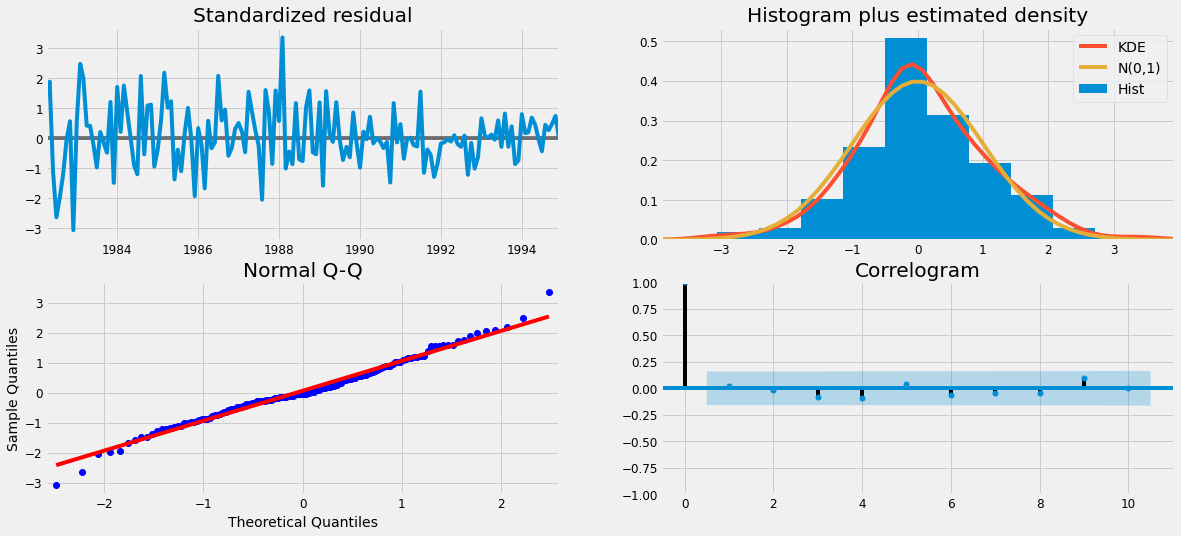

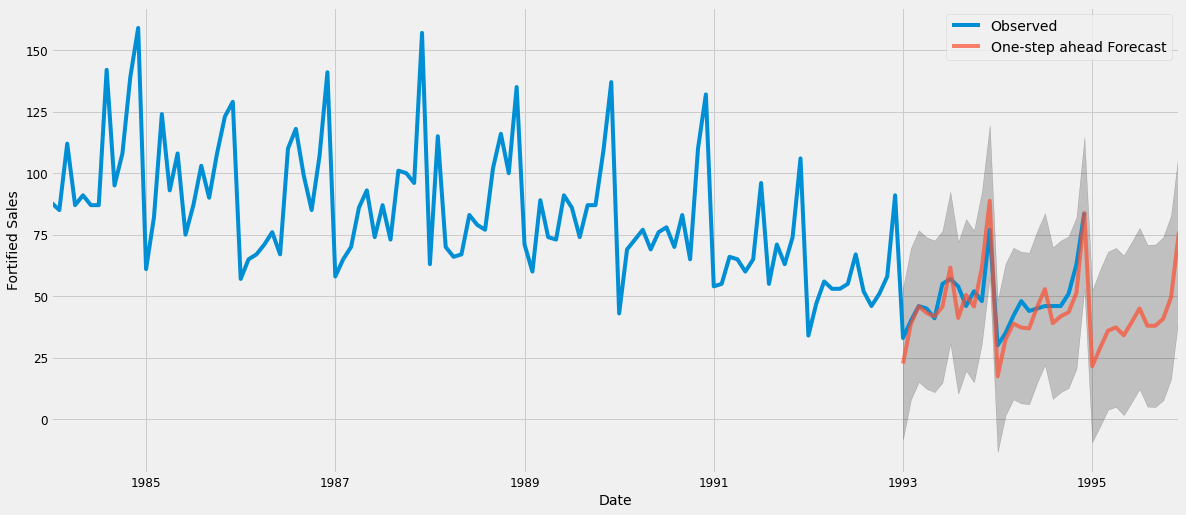

The Mean Squared Error of our forecasts is 6614641.4
The Root Mean Squared Error of our forecasts is 2571.89


In [40]:
Predicciones(y_rose, (1,1,1), (0,1,1,12))

## Sparkling

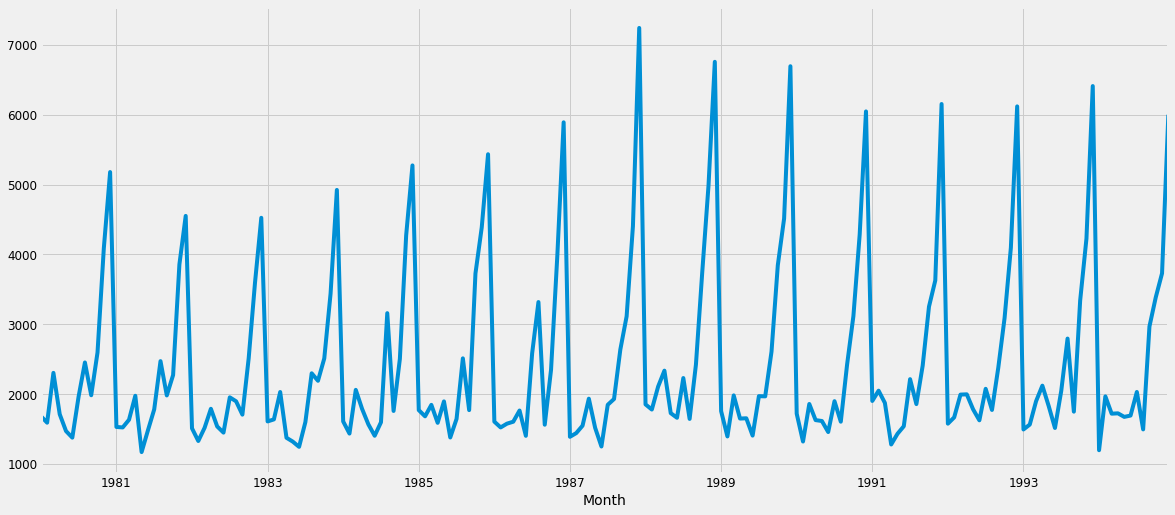

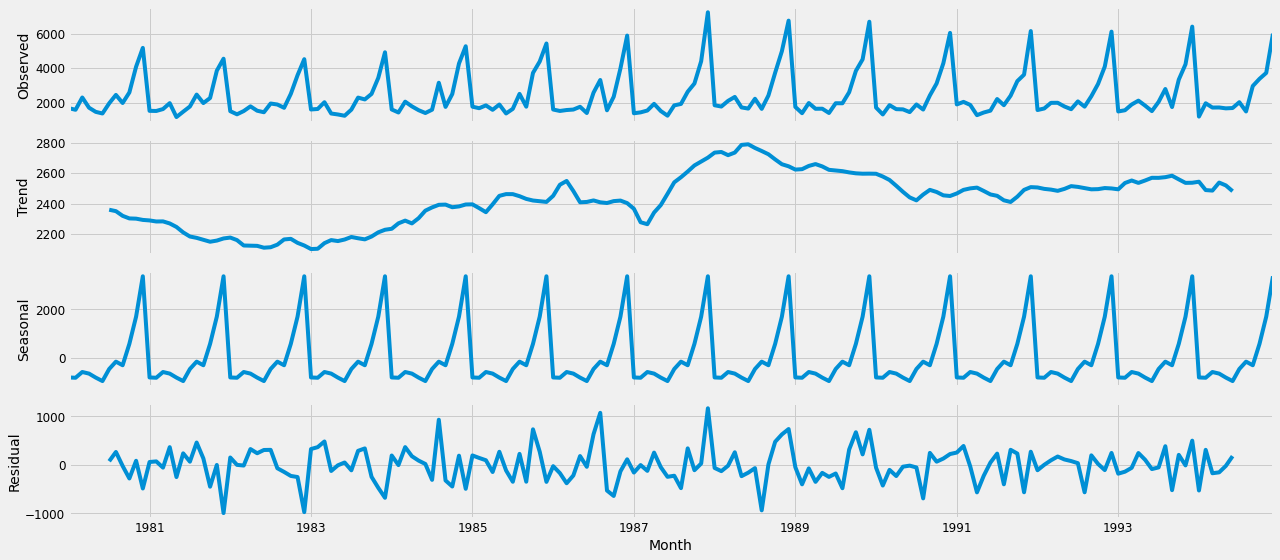

Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2271.5217326848706


In [41]:
y_sparkling = Reordenamiento_Meses(sparkling, 'sparkling ')
SARIMA_Param(y_sparkling)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0728      0.040    -26.801      0.000      -1.151      -0.994
ma.S.L12      -0.5847      0.055    -10.687      0.000      -0.692      -0.477
sigma2      1.353e+05   1.39e+04      9.768      0.000    1.08e+05    1.63e+05


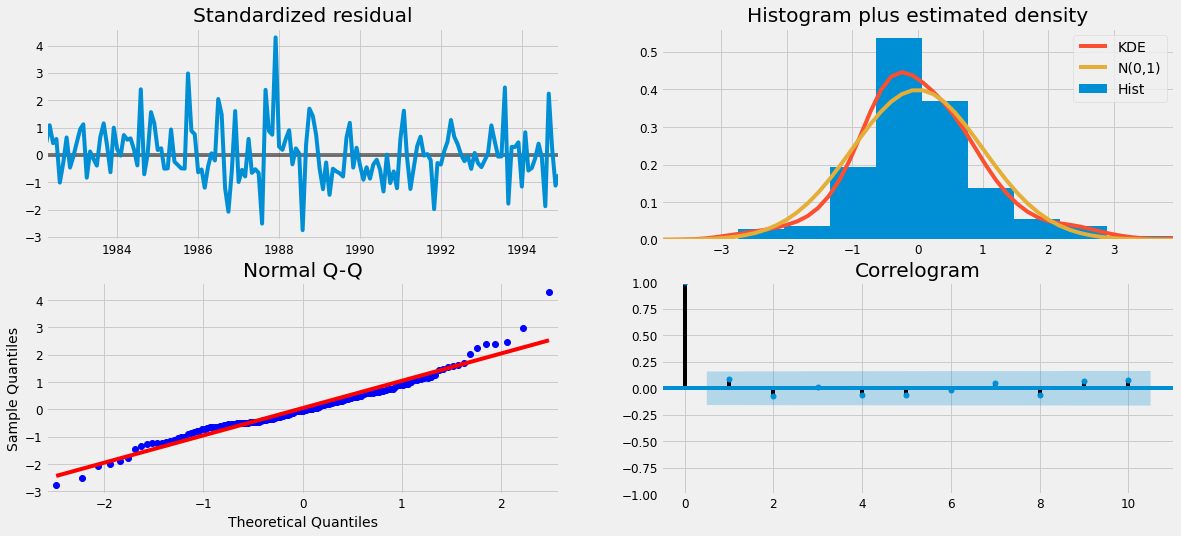

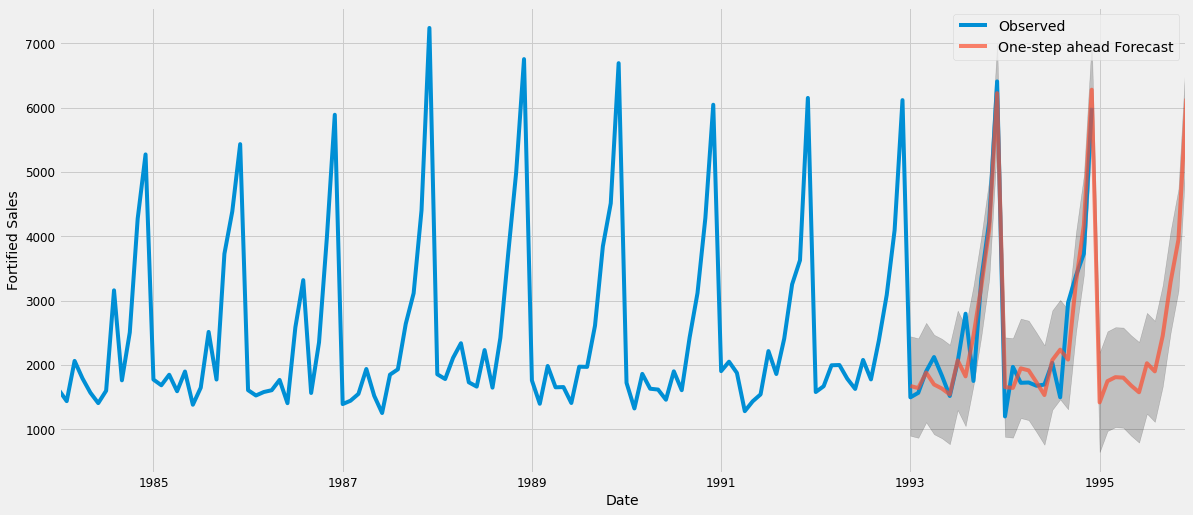

The Mean Squared Error of our forecasts is 8216767.43
The Root Mean Squared Error of our forecasts is 2866.49


In [42]:
Predicciones(y_sparkling,(0, 1, 1),(0, 1, 1, 12))

## Sweet white

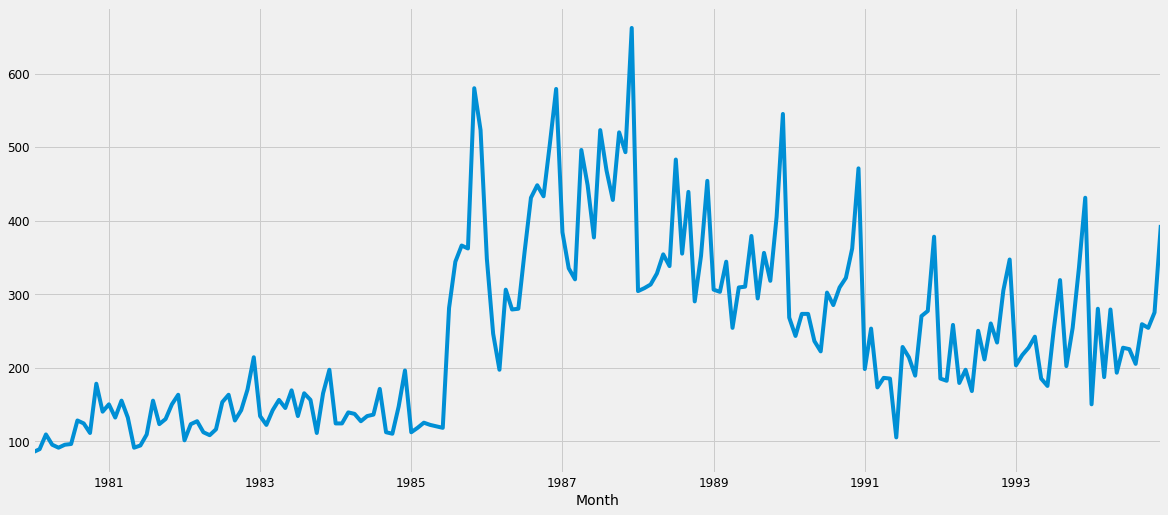

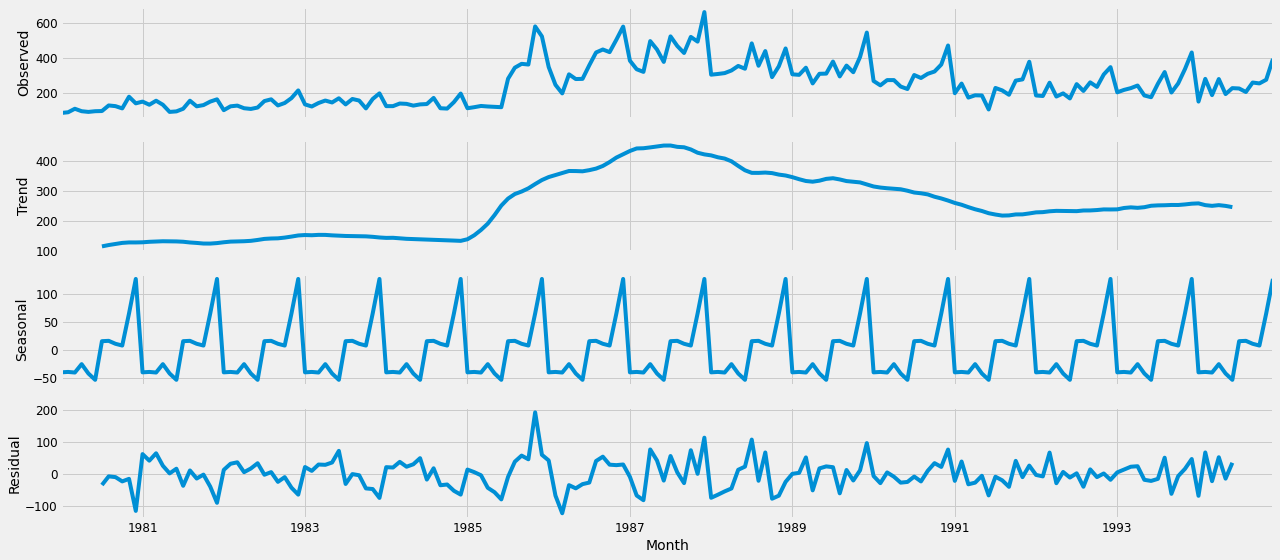

Minimo:  ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1671.9867567083738


In [43]:
y_sweet_white = Reordenamiento_Meses(sweet_white, 'Sweet white')
SARIMA_Param(y_sweet_white)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3687      0.125     -2.951      0.003      -0.614      -0.124
ma.L1         -0.1500      0.128     -1.173      0.241      -0.401       0.101
ar.S.L12       0.2326      0.076      3.057      0.002       0.083       0.382
ma.S.L12      -1.0000      0.097    -10.287      0.000      -1.191      -0.809
sigma2      2522.6391   3.85e-05   6.55e+07      0.000    2522.639    2522.639


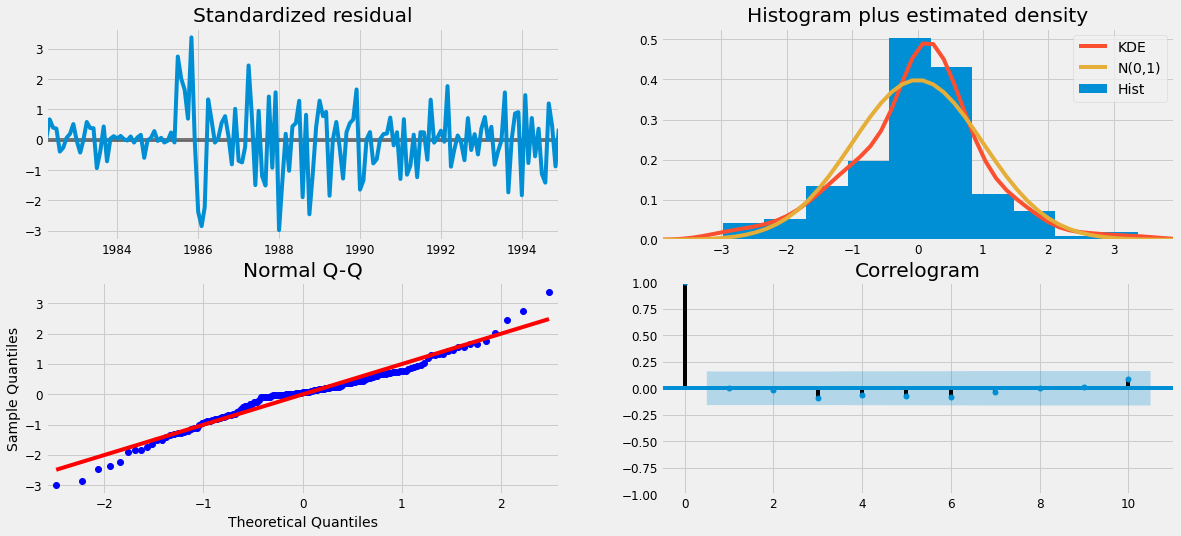

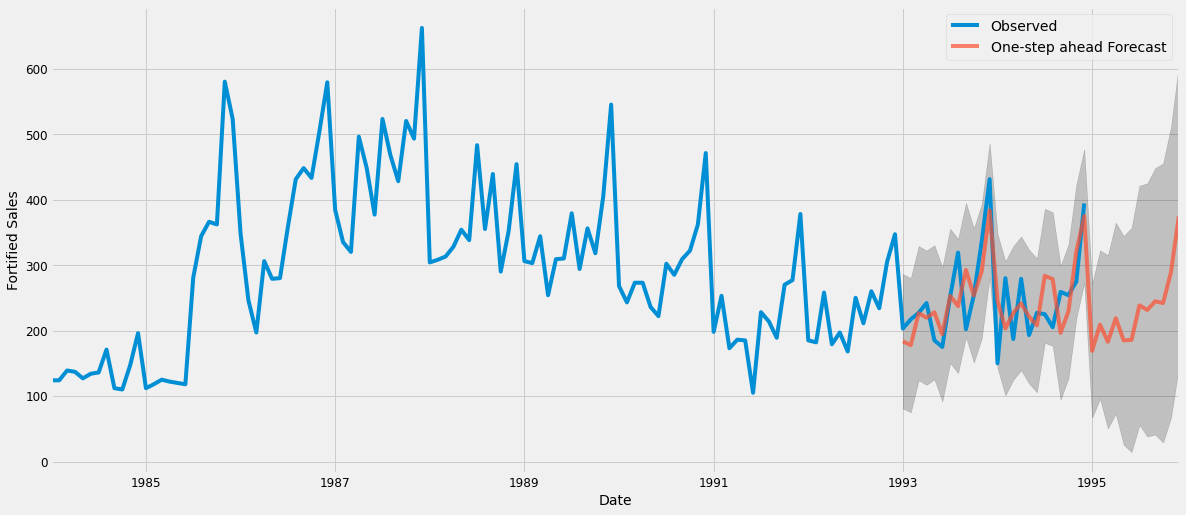

The Mean Squared Error of our forecasts is 5259613.46
The Root Mean Squared Error of our forecasts is 2293.38


In [44]:
Predicciones(y_sweet_white,(1, 1, 1),(1, 1, 1, 12))

## Dry white

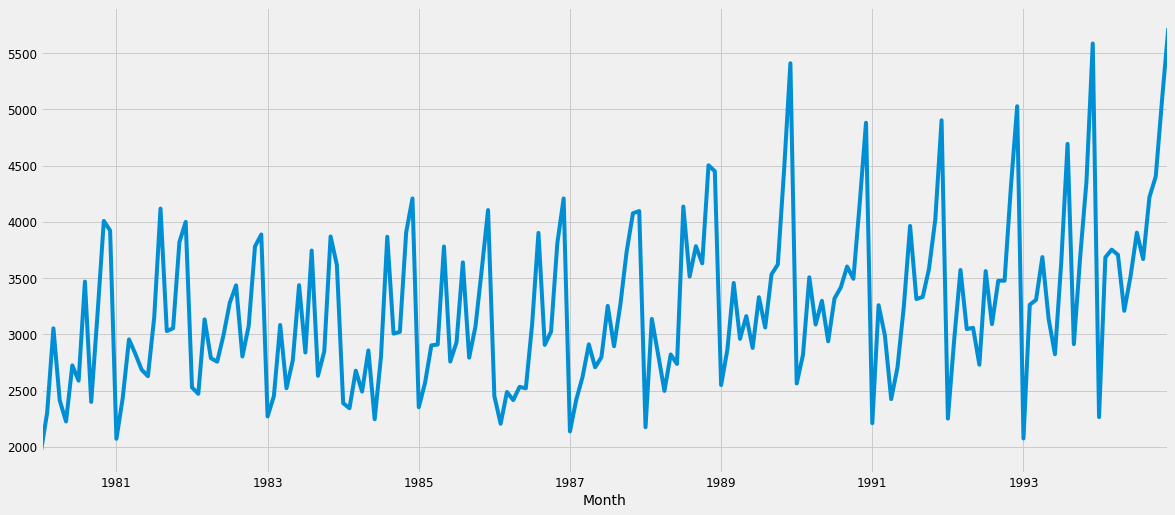

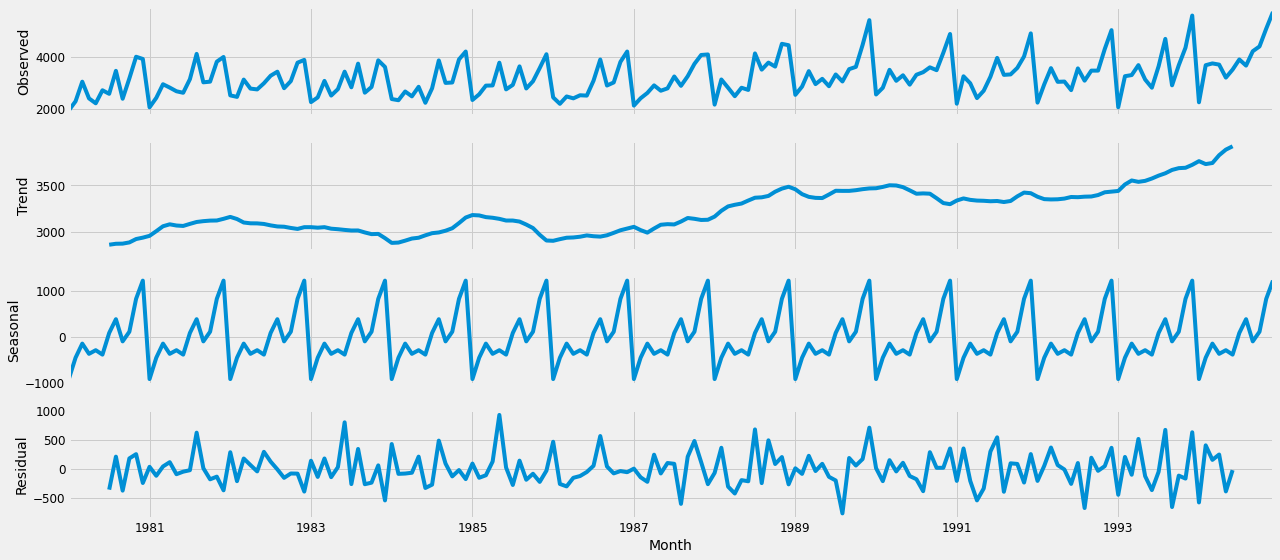

Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2233.242568479068


In [45]:
y_dry_white = Reordenamiento_Meses(dry_white, 'Dry white')
SARIMA_Param(y_dry_white)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8653      0.049    -17.746      0.000      -0.961      -0.770
ma.S.L12      -0.6713      0.064    -10.457      0.000      -0.797      -0.545
sigma2      1.209e+05   1.13e+04     10.739      0.000    9.88e+04    1.43e+05


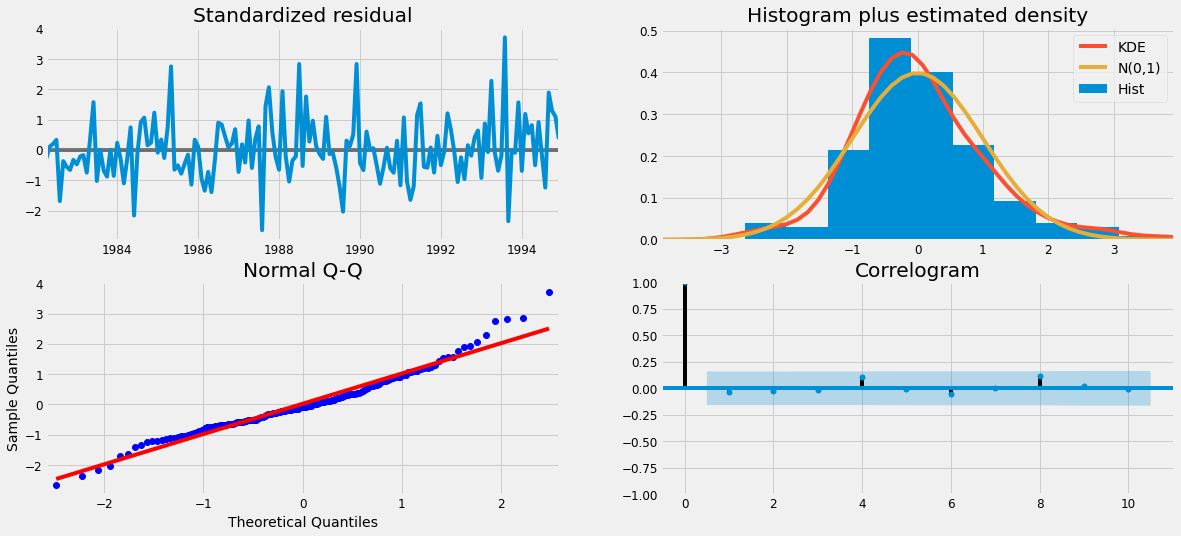

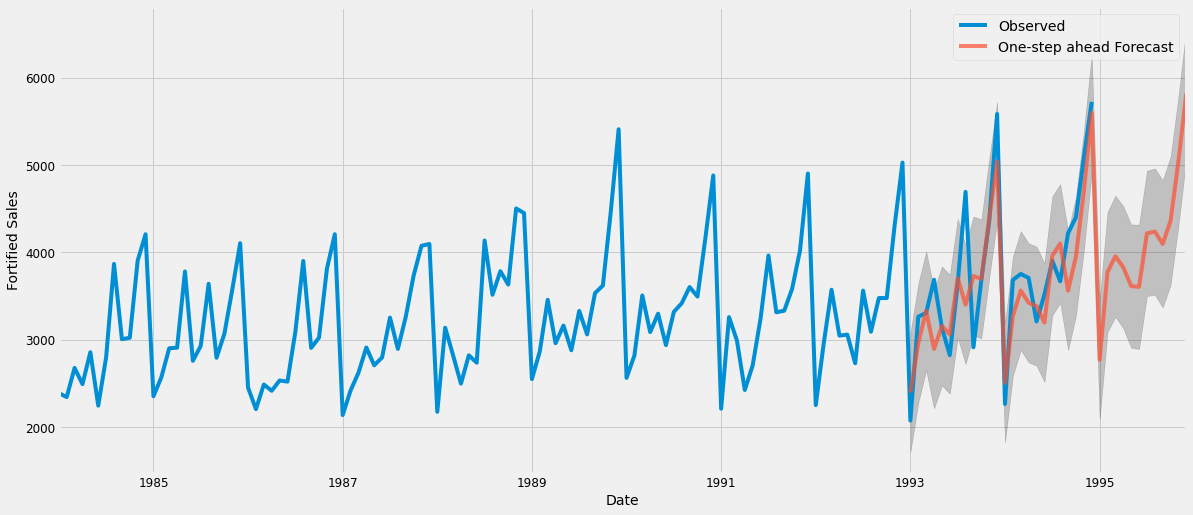

The Mean Squared Error of our forecasts is 6718995.45
The Root Mean Squared Error of our forecasts is 2592.1


In [46]:
Predicciones(y_dry_white,(0, 1, 1),(0, 1, 1, 12))

# 2.2: Desempeño de pronosticos dado conjuntos de entrenamiento y validación

## Funciones:

In [70]:
def Cjts_Training_Val(Y_Obj, Orden_Obj, Seas_Orden_Obj,Year_Obj, Plot=False):
  Training_Set = Y_Obj[:-12*Year_Obj]
  Val_Set = Y_Obj[-12*Year_Obj:]
  mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                order=Orden_Obj,
                                seasonal_order=Seas_Orden_Obj,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  results = mod.fit()
  Traininig_Pred = results.get_prediction(end = -12*Year_Obj, dynamic=False)
  Val_Pred = results.get_prediction(start = -12*Year_Obj,end = len(y_fortified) + 11, dynamic=False)
  Val_Pred_ci = Val_Pred.conf_int(alpha=0.2)
  if Plot:
    ax = Y_Obj['1984':].plot(label='Observed')
    Val_Pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
    ax.fill_between(Val_Pred_ci.index,
                    Val_Pred_ci.iloc[:, 0],
                    Val_Pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Fortified Sales')
    plt.legend()
    plt.show()
    y_forecasted = Val_Pred.predicted_mean
    y_truth = y_fortified['1994-11-01':]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
  return Traininig_Pred,Training_Set, Val_Pred, Val_Set, Val_Pred_ci

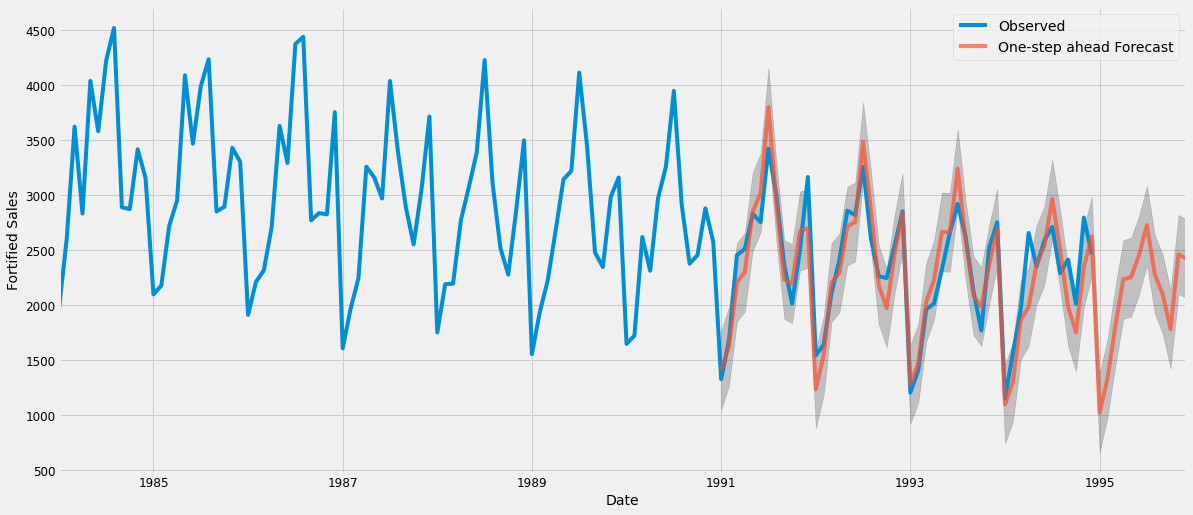

The Mean Squared Error of our forecasts is 116299.1
The Root Mean Squared Error of our forecasts is 341.03


In [73]:
Training_Pred_Fortified, Training_Fortified, Val_Pred_Fortified,Val_Fortified, Val_Pred_CI= Cjts_Training_Val(y_fortified, (0,1,1), (1,1,1,12), 4,True)

[ 3  9  5  6 14  3  4  2  1  1] [-377.93565159 -273.04530806 -168.15496452  -63.26462099   41.62572254
  146.51606607  251.40640961  356.29675314  461.18709667  566.07744021
  670.96778374]


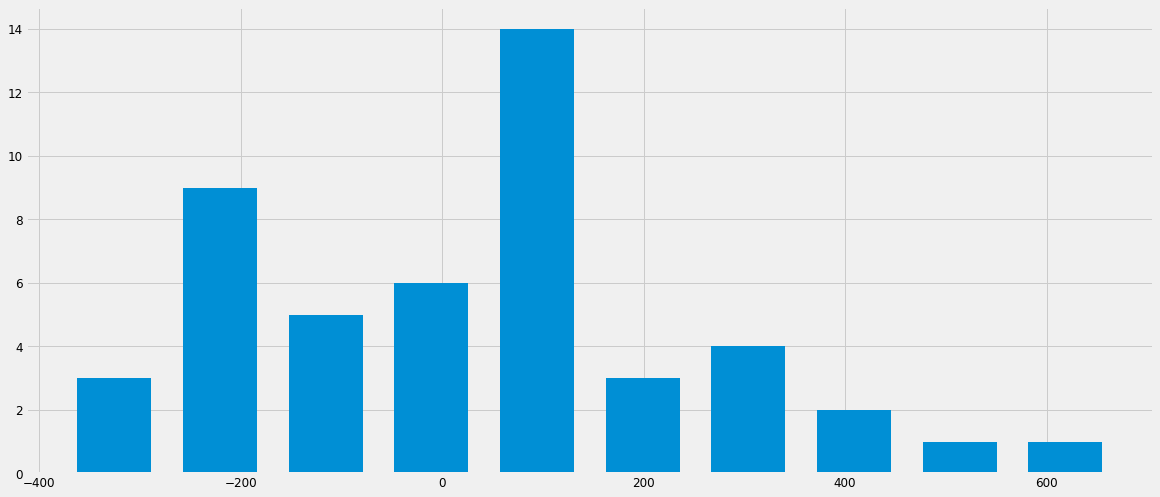

In [74]:
DataF = Val_Fortified - Val_Pred_Fortified.predicted_mean[:-12]
H, B = np.histogram(DataF, bins = 10)
print(H, B)
#print(DataF.hist(bins=10)) # La diferencia entre lo predicho y lo obtenido
width = 0.7 * (B[1] - B[0])
center = (B[:-1] + B[1:]) / 2
plt.bar(center, H, align='center', width=width)
plt.show()

In [75]:
print(Val_Pred_CI)

            lower Fortified  upper Fortified
1991-01-01      1053.062975      1770.260189
1991-02-01      1272.758954      1989.933101
1991-03-01      1851.365289      2568.513597
1991-04-01      1943.377491      2660.500895
1991-05-01      2493.777867      3210.877239
1991-06-01      2663.562093      3380.638274
1991-07-01      3444.408751      4161.462552
1991-08-01      2585.845322      3302.877527
1991-09-01      1877.833474      2594.844841
1991-10-01      1837.640168      2554.631432
1991-11-01      2319.313785      3036.285657
1991-12-01      2341.492624      3058.445698
1992-01-01       879.885734      1596.820413
1992-02-01      1183.555682      1900.473890
1992-03-01      1848.369579      2565.270248
1992-04-01      1937.752618      2654.636340
1992-05-01      2362.460810      3079.328144
1992-06-01      2399.981005      3116.832489
1992-07-01      3129.674741      3846.510898
1992-08-01      2509.015301      3225.836636
1992-09-01      1825.148465      2541.955466
1992-10-01

# 2.3 - 2.6

# 2.7: Histograma e intervalo de confianza

# Ejemplo

In [ ]:
df = pd.read_excel("C:/Users/ascan/Downloads/Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [ ]:
furniture['Order Date'].min(), furniture['Order Date'].max()

In [ ]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

In [ ]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [ ]:
furniture = furniture.set_index('Order Date')
furniture.index

In [ ]:
y = furniture['Sales'].resample('MS').mean()

In [ ]:
y['2017':]

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))